In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
# Load datasets
train_df = pd.read_csv('./data/house-train.csv')
test_df = pd.read_csv('./data/house-test.csv')

# Define categorical features for one-hot encoding
categorical_features = ['Neighborhood', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 
                        'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']

# Combine train and test data for consistent preprocessing
combined_df = pd.concat([train_df, test_df], sort=False)

# Apply one-hot encoding
one_hot_encoder = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

# Transform the data
combined_df_encoded = one_hot_encoder.fit_transform(combined_df[categorical_features])

# Retrieve the feature names generated by one-hot encoding
encoded_feature_names = one_hot_encoder.named_transformers_['onehot'].get_feature_names_out(categorical_features)

# Convert the array back to a DataFrame with new feature names
combined_df_encoded = pd.DataFrame(combined_df_encoded, columns=encoded_feature_names)

# Add the SalePrice back to the DataFrame
combined_df_encoded['SalePrice'] = combined_df['SalePrice'].values

# Handling missing values in the target (SalePrice might have NaN due to concatenation)
combined_df_encoded = combined_df_encoded.dropna(subset=['SalePrice'])

# Split back into training and testing data
train_df_encoded = combined_df_encoded.iloc[:len(train_df)]
test_df_encoded = combined_df_encoded.iloc[len(train_df):]

# Splitting into features and target
X = train_df_encoded.drop('SalePrice', axis=1)
y = train_df_encoded['SalePrice']

# Splitting the training data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the target variable (SalePrice)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),  # Adjusted input size for one-hot encoded features
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output layer for regression
        )
        
    def forward(self, x):
        return self.network(x)

# Instantiate the model with the corrected number of input features
model = MLP(input_size=X_train.shape[1])

# Correctly defined optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)#LR is optim is at 0.001


In [24]:
criterion = nn.MSELoss()

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Training loop with loss tracking
train_losses = []
val_losses = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')


Epoch 10, Training Loss: 0.8824801445007324, Validation Loss: 1.1204756498336792
Epoch 20, Training Loss: 0.6617147326469421, Validation Loss: 0.8182721734046936
Epoch 30, Training Loss: 0.47388625144958496, Validation Loss: 0.5523906946182251
Epoch 40, Training Loss: 0.41269803047180176, Validation Loss: 0.4916345179080963
Epoch 50, Training Loss: 0.37257084250450134, Validation Loss: 0.4813050627708435
Epoch 60, Training Loss: 0.34356170892715454, Validation Loss: 0.45856592059135437
Epoch 70, Training Loss: 0.32108834385871887, Validation Loss: 0.4584033489227295
Epoch 80, Training Loss: 0.2995002567768097, Validation Loss: 0.4511992633342743
Epoch 90, Training Loss: 0.2781558036804199, Validation Loss: 0.44636765122413635
Epoch 100, Training Loss: 0.2576838433742523, Validation Loss: 0.4485063850879669


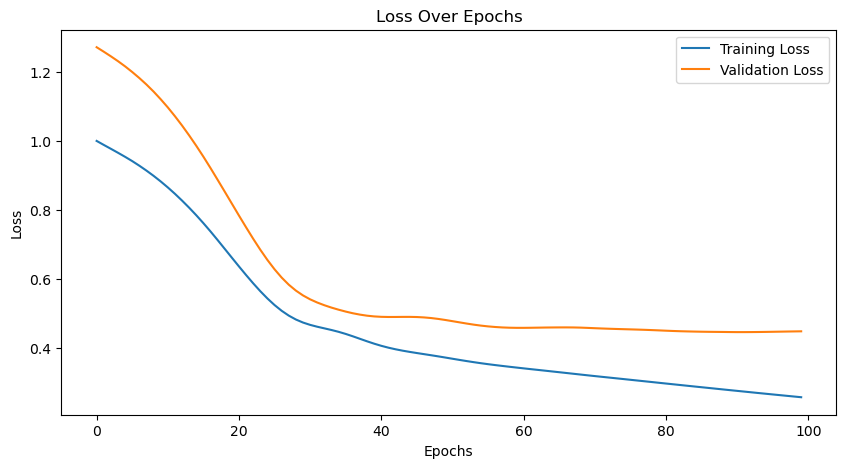

Validation Loss: 0.4485063850879669
RMSE on Validation Set: 0.6697061657905579


In [25]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate model performance on validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    val_loss = criterion(val_predictions, y_val_tensor)
    print('Validation Loss:', val_loss.item())

# Calculating RMSE for model performance
rmse_val = torch.sqrt(val_loss).item()
print(f'RMSE on Validation Set: {rmse_val}')
